# The goal of this notebook is to show how to compute and analyze the technical lag of *direct* dependencies of npm packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load DATA

### npm dependencies

In [2]:
npm_deps = pd.read_csv('./data/npm_dependencies.zip')

In [3]:
npm_deps.sample()

,package,version,date,dependency,used_version
21200683,andari,0.0.7,2017-09-17,yo,2.0.0


### the history of all package versions

In [4]:
npm_versions = pd.read_csv('./data/npm_versions.zip')

In [5]:
npm_versions.sample()

,package,version,date
2205787,loglog,0.1.5,2014-08-28


Let's make date into to the correct format

In [7]:
npm_deps['date'] = pd.to_datetime(npm_deps['date'])
npm_versions['date'] = pd.to_datetime(npm_versions['date'])

###### How many distinct npm packages have at least one direct dependency?

In [8]:
npm_deps.package.unique().size

429055

##### How many distinct npm packages are used as dependency by at least one other npm package?

In [9]:
npm_deps.dependency.unique().size

143117

###### How many dependencies does each distinct package release have?

In [10]:
numDeps = npm_deps.groupby(['package','version']).count()[['dependency']]

###### Distribution of the number of dependencies (grouped by package release)

In [11]:
numDeps.describe()

,dependency
count,3.307216e+06
mean,6.552553e+00
std,9.428491e+00
min,0.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,7.000000e+00
max,9.960000e+02


###### Visualization 
We will make us of boxplots to show the distribution. Violin or boxen plots can be use as well (e.g. sns.boxenplot())

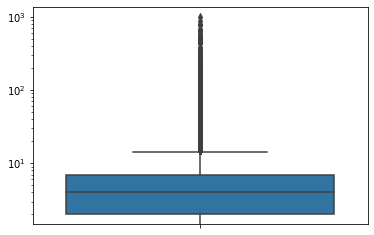

In [12]:
ax = sns.boxplot(y=['dependency'], data=numDeps)
ax.set_yscale('log')

#### Now let's compute the technical lag:

To compute the technical lag, we will rely on two auxiliary functions:

**IDEAL** = The latest (i.e., the most recent) available release of a package

Note that the **latest available release** is different from the **highest available release**.
The **latest available release** refers to the most recent release of a package (in *time*), while the
**highest available release** refers to the package with the highest available version number.
**TIME LAG**= The difference in ***time*** between two given releases of the same package.

**VERSION LAG**= The difference in ****number of versions**** between two given releases of the same package.


Sort the list of package versions by ascending release dates (i.e., from oldest to latest):

In [13]:
npm_versions.sort_values(['date','version'], inplace=True)

Assign to each package version a different number, corresponding to its position in the sorted list.

In [14]:
npm_versions['order'] = npm_versions.groupby(['package']).cumcount()

In [15]:
print('Number of dependencies:', len(npm_deps))

Number of dependencies: 21674488


Include the date and the order of each dependency version to the **npm_deps** dataframe

In [16]:
npm_deps = (npm_deps
           .merge(npm_versions.rename(columns={'date':'dep_date',
                                              'package':'dependency',
                                              'version':'used_version'}),
                 on =['dependency','used_version'])
            .dropna()
           )
print('Number of dependencies:', len(npm_deps))

Number of dependencies: 21323888


Notice that about 1.6% of all dependencies are ignored. These dependencies couldn't be found in the history of package versions.

Let's check our dataframe now

In [17]:
npm_deps.sample()

,package,version,date,dependency,used_version,dep_date,order
15999439,@sanity/default-layout,0.105.13,2017-05-16,react-click-outside,2.3.1,2017-05-09,13


Now, we have, for each npm package release, all information about the **used versions** of its dependencies.

Get the information about the **latest available version** of these dependencies at the release date of each package release.

In [18]:
npm_deps = pd.merge_asof(
            (npm_deps
             .sort_values('date')),
            (npm_versions
             .rename(columns={'package':'dependency',
                              'version':'latest_version',
                              'date':'latest_date',
                              'order':'latest_order'
                             })
             .sort_values(['latest_date','latest_version'])
            ),
            left_on='date',
            right_on='latest_date',
            left_by='dependency',
            right_by='dependency',
        )
print('Number of dependencies:', len(npm_deps))

Number of dependencies: 21323888


Check how many outdated dependencies each package release has:

In [19]:
npm_deps['outdated'] = (npm_deps.latest_order == npm_deps.order)

In [20]:
numDeps = npm_deps.groupby(['package','version','outdated']).count()[['dependency']].reset_index()

In [21]:
numDeps.groupby('outdated').describe()

dependency                                               
              count      mean       std  min  25%  50%  75%    max
outdated                                                          
False     1481128.0  3.300803  4.715964  1.0  1.0  2.0  3.0  358.0
True      3102482.0  5.297364  7.192182  1.0  2.0  3.0  6.0  657.0

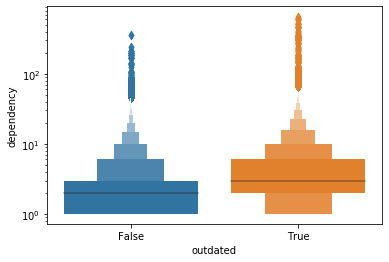

In [22]:
ax = sns.boxenplot(y='dependency', x='outdated', data=numDeps)
ax.set_yscale('log')

##### It seems that 67.6% of the dependencies are up-to-date. 

### Computing the technical lag using ***versions***.
We will compute, for each package release, the technical lag in terms of the *number of missed versions* of its dependencies.


In [23]:
npm_deps['versionLag'] = npm_deps.latest_order - npm_deps.order

Distribution of the version lag for each package release:

In [24]:
# For all dependencies
npm_deps.versionLag.describe()

count    2.132389e+07
mean     1.659756e+00
std      7.201368e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.750000e+02
Name: versionLag, dtype: float64

In [25]:
# For outdated dependencies ONLY
npm_deps.query('versionLag != 0').versionLag.describe()

count    4.888912e+06
mean     7.239331e+00
std      1.363097e+01
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      8.000000e+00
max      9.750000e+02
Name: versionLag, dtype: float64

### Aggregate the technical lag at the level of a package release, as the sum of version lags of all its dependencies

In [26]:
numDeps = npm_deps.groupby(['package','version','date'])['versionLag'].sum().reset_index()

In [27]:
# For all dependencies 
numDeps.versionLag.describe()

count    3.288633e+06
mean     1.076206e+01
std      3.727685e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+00
max      6.031000e+03
Name: versionLag, dtype: float64

In [28]:
# For outdated dependencies ONLY
numDeps.query('versionLag != 0').versionLag.describe()

count    1.481128e+06
mean     2.389561e+01
std      5.264498e+01
min      1.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.100000e+01
max      6.031000e+03
Name: versionLag, dtype: float64

### Analyse the evolution of this aggregated version lag over time.

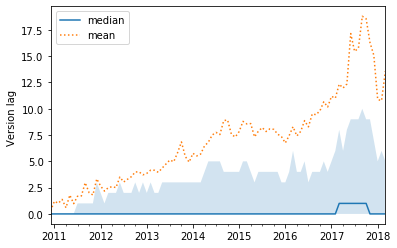

In [29]:
# For all dependencies 
size=[12,20,70]
df_=(numDeps
     .groupby(pd.Grouper(key='date', freq='1M'))['versionLag']
     .describe()[['mean', '25%', '50%', '75%']] 
    )

df_['50%'].rename('median').plot()
ax=df_['mean'].plot(style=':')
ax.fill_between(df_.index, df_['25%'], df_['75%'], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='Version lag '
)
ax.legend(loc='upper left')


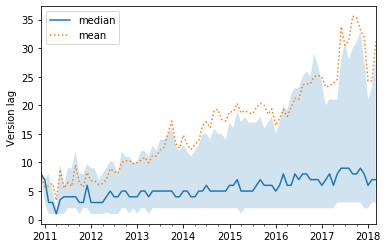

In [30]:
# For outdated dependencies ONLY
size=[12,20,70]
df_=(numDeps.query('versionLag != 0')
     .groupby(pd.Grouper(key='date', freq='1M'))['versionLag']
     .describe()[['mean', '25%', '50%', '75%']] 
    )

df_['50%'].rename('median').plot()
ax=df_['mean'].plot(style=':')
ax.fill_between(df_.index, df_['25%'], df_['75%'], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='Version lag '
)
ax.legend(loc='upper left')


### It seems that aggregated version lag of package releases is increasing over time. 
it could be possible that more recent package releases tend to have more outdated dependencies.